******************** Start ********************


100%|██████████| 1/1 [00:14<00:00, 14.85s/it]


You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 3
Starting trial  2 / 3
Starting trial  3 / 3
Optimized regularization, optimal lambda =  4.049565169663997e-06
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_regularizer_flag to True.


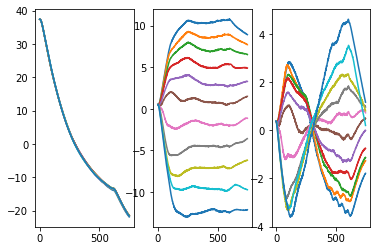

<class 'numpy.ndarray'>


In [1]:
from typing import Iterable, List

import numpy as np
import torch
from cgtasknet.tasks.reduce import (
    CtxDMTaskParameters,
    DMTaskParameters,
    DMTaskRandomModParameters,
    GoDlTaskParameters,
    GoDlTaskRandomModParameters,
    GoRtTaskParameters,
    GoRtTaskRandomModParameters,
    GoTaskParameters,
    GoTaskRandomModParameters,
    MultyReduceTasks,
    RomoTaskParameters,
    RomoTaskRandomModParameters,
)
from dPCA import dPCA
from matplotlib import pyplot as plt
from tqdm import tqdm


def generate_task_romo_dm_ctx_go_gort_godl(
    values: Iterable[float], romo_number_fix: int = 0, romo_fix: float = 0.5
) -> List[List]:
    """
    Функция, генерирующая набор задач для тестирования.
    :param tasks:
    :param values:
    :param romo_number_fix:
    :param romo_fix:
    :return:
    """
    tasks = [
        "RomoTask1",
        "RomoTask2",
        "DMTask1",
        "DMTask2",
        "CtxDMTask1",
        "CtxDMTask2",
        "GoTask1",
        "GoTask2",
        "GoRtTask1",
        "GoRtTask2",
        "GoDlTask1",
        "GoDlTask2",
    ]

    return_tasks = [[] for _ in range(len(tasks))]

    for value in values:
        batch_size = 1
        romo_parameters = RomoTaskRandomModParameters(
            romo=RomoTaskParameters(
                delay=1.0,
                # positive_shift_delay_time=1.4,
                trial_time=0.18,
                # positive_shift_trial_time=0.2,
                value=(romo_fix, value) if romo_number_fix == 0 else (value, romo_fix),
            ),
        )
        dm_parameters = DMTaskRandomModParameters(
            dm=DMTaskParameters(trial_time=0.6, value=value)
        )
        ctx_parameters = CtxDMTaskParameters(dm=dm_parameters.dm, value=(value, value))
        go_parameters = GoTaskRandomModParameters(
            go=GoTaskParameters(
                trial_time=0.6,
                # positive_shift_trial_time=0.8,
                value=value,
            )
        )
        gort_parameters = GoRtTaskRandomModParameters(
            go=GoRtTaskParameters(
                trial_time=0.6,
                # positive_shift_trial_time=0.8,
                value=value,
            )
        )
        godl_parameters = GoDlTaskRandomModParameters(
            go_dl=GoDlTaskParameters(
                go=GoTaskParameters(trial_time=0.18, value=value),
                delay=1.0,
                # positive_shift_delay_time=1.4,
            )
        )

        task_dict = {
            tasks[0]: romo_parameters,
            tasks[1]: romo_parameters,
            tasks[2]: dm_parameters,
            tasks[3]: dm_parameters,
            tasks[4]: ctx_parameters,
            tasks[5]: ctx_parameters,
            tasks[6]: go_parameters,
            tasks[7]: go_parameters,
            tasks[8]: gort_parameters,
            tasks[9]: gort_parameters,
            tasks[10]: godl_parameters,
            tasks[11]: godl_parameters,
        }

        tasks_sequence = [
            MultyReduceTasks(
                tasks=task_dict,
                batch_size=batch_size,
                delay_between=0,
                enable_fixation_delay=True,
                task_number=i,
                mode="value",
            )
            for i in range(len(tasks))
        ]
        for i in range(len(tasks_sequence)):
            return_tasks[i].append(tasks_sequence[i])
    return return_tasks


def dpca_run(
    network,
    tasks,
    device,
    number_of_trials,
    hidden_size,
):
    actR_v_out = []
    actR_a_out = []
    for type_task in tqdm(tasks):
        actR_v = None
        actR_a = None
        value = 0
        for task_number in type_task:
            for trial in range(number_of_trials):
                data, _ = task_number.dataset()
                data = torch.from_numpy(data).type(torch.float).to(device)
                out, states, _ = network(data)
                a, v = [], []
                for j in range(len(states)):
                    v.append(states[j].v)
                    a.append(states[j].a)
                a = torch.stack(a).detach()
                v = torch.stack(v).detach()
                if actR_v is None and actR_a is None:
                    actR_v = np.zeros(
                        (
                            number_of_trials,
                            hidden_size,
                            len(tasks[0]),
                            len(data)
                            # int((dmparams.answer_time + dmparams.trial_time) / dmparams.dt),
                        )
                    )

                    actR_a = np.zeros_like(actR_v)
                actR_v[trial, :, value, :] = v[:, 0, :].T.cpu().numpy()
                actR_a[trial, :, value, :] = a[:, 0, :].T.cpu().numpy()
            value += 1
        actR_v_out.append(actR_v)
        actR_a_out.append(actR_a)
    return actR_v_out, actR_a_out


def dpca_calculate(actRs):
    result = []
    for actR in actRs:
        R = np.mean(actR, 0)
        R -= np.mean(R.reshape((actR.shape[1], -1)), 1)[:, None, None]
        dpca = dPCA.dPCA(labels="st", regularizer="auto")
        dpca.protect = ["t"]
        dpca.opt_regularizer_flag = True
        Z = dpca.fit_transform(R, actR)
        result.append(Z)
    return result


print("*" * 20, "Start", "*" * 20)
values = np.arange(0, 1.1, 0.1)
check_tasks = generate_task_romo_dm_ctx_go_gort_godl(values)
from cgtasknet.net import SNNlifadex
from norse.torch import LIFAdExParameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_size, output_size = check_tasks[0][0].feature_and_act_size
hidden_size = 450

neuron_parameters = LIFAdExParameters(
    v_th=torch.as_tensor(0.65),
    tau_ada_inv=0.5,
    alpha=100,
    method="super",
    # rho_reset = torch.as_tensor(5)
)
model = SNNlifadex(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
    return_spiking=True,
).to(device)
model.load_state_dict(
    torch.load(
        (
            r"A:\src\multy_task\notebooks\train\reduce\lif_adex\romo_dm_ct_go_gort_godl\Train_dm_and_romo_task_reduce_lif_adex_without_refrac_random_delay_long_a_alpha_100_N_450"
        )
    )
)

actR_v, acrR_a = dpca_run(model, check_tasks[0:1], device, 2, hidden_size)
# z_v_list = dpca_calculate(actR_v)
z_a_list = dpca_calculate(acrR_a)
Z = z_a_list[0]
time = np.arange(actR_v[0].shape[-1])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(actR_v[0].shape[2]):
    ax1.plot(time, Z["t"][0, s])
for s in range(actR_v[0].shape[2]):
    ax2.plot(time, Z["s"][0, s])
for s in range(actR_v[0].shape[2]):
    ax3.plot(time, Z["st"][0, s])
plt.show()
plt.close()
print(type(Z["t"][0, :]))

In [4]:
for key in Z:
    print(key)

s
t
st


In [6]:
Z["s"].shape

(10, 11, 750)

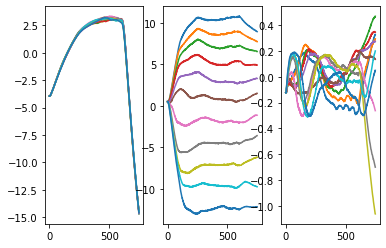

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for s in range(actR_v[0].shape[2]):
    ax1.plot(time, Z["t"][1, s])
for s in range(actR_v[0].shape[2]):
    ax2.plot(time, Z["s"][0, s])
for s in range(actR_v[0].shape[2]):
    ax3.plot(time, Z["st"][4, s])
plt.show()
plt.close()

['CtxDM1',
 'CtxDM2',
 'DMTask1',
 'DMTask2',
 'GoDlTaskRandomMod',
 'GoDlTaskRandomMod',
 'GoRtTaskRandomMod',
 'GoRtTaskRandomMod',
 'GoTaskRandomMod',
 'GoTaskRandomMod',
 'RomoTask1',
 'RomoTask2']